In [62]:
import requests
import pandas as pd
import datetime
import time
import random
import re
import spacy
import yfinance as yf
import gensim
import numpy as np

In [81]:
from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from bertopic import BERTopic
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import trains

In [79]:
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

# Scraping news dataset

In [4]:
def scrape_news(query, start_date, end_date, max_entries = 5):
    """
    Scrapes news articles from Google News RSS for a given query and filters them by data.

    Parameters:
        query(str): the stock or company name to search for.
        start_date(date): the start date for filtering articles.
        end_date(date): the end date for filtering articles.
        max_entries(int): number of times to retry incase of request failure.

    returns:
        pd.DataFrame: a dataframe consisting of article title, link, and publication date
    """
    articles = []
    url = f"https://news.google.com/rss/search?q={query}+after:{start_date}+before:{end_date}"
    for i in range(max_entries):
        try:
            response = requests.get(url)
            break
        except exception as e:
            print(f"an error occured in requesting {e}")
            print(f"retrying attempt {i}")
            time.sleep(random.uniform(2,10))
        
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.find_all('item')
    
    for item in items:
        title = item.title.text
        link = item.link.text
        pub_date = item.pubDate.text
        articles.append({'title': title, 'link': link, 'pub_date': pub_date})
    return pd.DataFrame(articles)

In [5]:
def scrape_news_over_date_range(query, start_date, end_date):
    """
    Scrapes news articles over a given date range by iterating through months.

    Parameters:
        query(str): The stock or company name to search for.
        start_date(str): the start date in 'yyyy-mm-dd' format.
        end_date(str): the end date in 'yyyy-mm-dd' format.

    Returns:
        pd.DataFrame: A DataFrame collected across the date range.
    """
    start_date_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()

    all_articles = pd.DataFrame()

    current_date = start_date_dt

    while current_date<end_date_dt:
        next_date = min(current_date + relativedelta(months = 1), end_date_dt)
        
        start_str = current_date.strftime('%Y-%m-%d')
        end_str = next_date.strftime('%Y-%m-%d')
        month_articles = scrape_news(query, start_str, end_str)
        all_articles = pd.concat([all_articles, month_articles], ignore_index=True)
        current_date = next_date

    return all_articles    

In [6]:
def scrape_and_save_news(queries, start_date, end_date):
    """
    Scrapes news articles for mutliple queries over a gives date range and saves each result to a csv file

    Parameters:
        queries(list): A list of stock or company names to search for.
        start_date(str): the start date in 'yyyy-mm-dd' format.
        end_date(str): the end date in 'yyyy-mm-dd' format.

    Outputs:
        CSV files named after each query, containing scraped news articles.
    """
    for query in queries:
        articles = scrape_news_over_date_range(query, start_date, end_date)
        output_csv = f"{query}.csv"
        articles.to_csv(output_csv, index=False)
        print(f"Saved {query} articles to {output_csv}")

In [7]:
queries = ["Reliance", "Microsoft", "Google"]
start_date = '2020-01-01'
end_date = '2022-12-31'
scrape_and_save_news(queries, start_date, end_date)

Saved Reliance articles to Reliance.csv
Saved Microsoft articles to Microsoft.csv
Saved Google articles to Google.csv


In [8]:
news_df1 = pd.read_csv('Reliance.csv')
news_df2 = pd.read_csv('Microsoft.csv')
news_df3 = pd.read_csv('Google.csv')

# Pre-Processing

In [9]:
def clean_text(text: str):
    """
    Cleans the text and returns in form of tokens.

    Parameters:
    text(str): string to be cleaned.

    Returns:
    str: a joint of tokens created.
    """
    text = text.lower()
    doc = nlp(text.lower())

    tokens = [token.lemma_ for token in doc 
             if not token.is_stop 
             and not token.is_punct 
             and token.text not in ["'", '"']]

    return ' '.join(tokens)

In [10]:
news_df1['cleaned_text'] = news_df1['title'].apply(clean_text)
news_df2['cleaned_text'] = news_df2['title'].apply(clean_text)
news_df3['cleaned_text'] = news_df3['title'].apply(clean_text)

# Extracting Stock Prices for supervised training

In [11]:
start_date = '2022-01-01'
end_date = '2022-12-31'

stock_symbols = {'Reliance': 'RELIANCE.NS', 'Microsoft': 'MSFT', 'Google': 'GOOGL'}

date_range = pd.date_range(start = start_date, end = end_date, freq = 'B') # 'B' for business days

def fetch_stock_data(symbol:str, max_entries =3):
    """
    fetches stock data from yahoo.

    Parameters:
    symbol(str): symbol corresponding to the country name.
    max_entries(int): no. of retries in fetching if the fetch fails.

    Returns: 
    pd.DataFrame: dataset containing stockprices
    """
    for i in range(max_entries):
        try:
            stock_data = yf.download(symbol, start= start_date, end= end_date)
        except Exception as e:
            print (f'error fetching data {e}; retrying attempt {i}.....')
        time.sleep(random.uniform(2,5))

        return stock_data

In [12]:
for company, symbol in stock_symbols.items():
    stock_data = fetch_stock_data(symbol)
    stock_data.reset_index(inplace = True)
    output_csv = f'{company}_stock_prices.csv'
    stock_data.to_csv(output_csv, index = False)
    print(f"stock_price for {company} saved")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

stock_price for Reliance saved



[*********************100%***********************]  1 of 1 completed

stock_price for Microsoft saved


stock_price for Google saved


In [13]:
stock_df1 = pd.read_csv('Reliance_stock_prices.csv')
stock_df2 = pd.read_csv('Microsoft_stock_prices.csv')
stock_df3 = pd.read_csv('Google_stock_prices.csv')

# Sentiment Scores

In [14]:
news_df1['sentiment'] = news_df1['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df2['sentiment'] = news_df2['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df3['sentiment'] = news_df3['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Merging the needed dataset

In [15]:
def merge_data(news_df:pd.DataFrame, stock_df:pd.DataFrame, company:str):
    """
    Merge the news dataframe with stock prices dataframe for every company

    Parametes:
        news_df(pd.DataFrame): dataframe containing the features.
        stock_df(pd.DataFrame): dataframe containing the the stock prices
        company(str): company to which the dataframes belong to.

    Output:
        Saves csv file of merged pdf under the name  "merged_data_{company}.csv".
    """
    news_df['pub_date'] = pd.to_datetime(news_df['pub_date']).dt.date
    stock_df['Date'] = pd.to_datetime(news_df['pub_date']).dt.date

    merged_df = pd.merge(news_df, stock_df, left_on = 'pub_date', right_on = 'Date', how = 'inner')

    output_csv = f'merged_data_{company}.csv'
    merged_df.to_csv(output_csv, index = False)
    print(f"merged data for company: {company}")

In [16]:
merge_data(news_df1, stock_df1, 'Reliance')
merge_data(news_df2, stock_df2, 'Microsoft')
merge_data(news_df3, stock_df3, 'Google')

merged data for company: Reliance
merged data for company: Microsoft
merged data for company: Google


In [85]:
df1 = pd.read_csv('merged_data_Reliance.csv')
df2 = pd.read_csv('merged_data_Microsoft.csv')
df3 = pd.read_csv('merged_data_Google.csv')

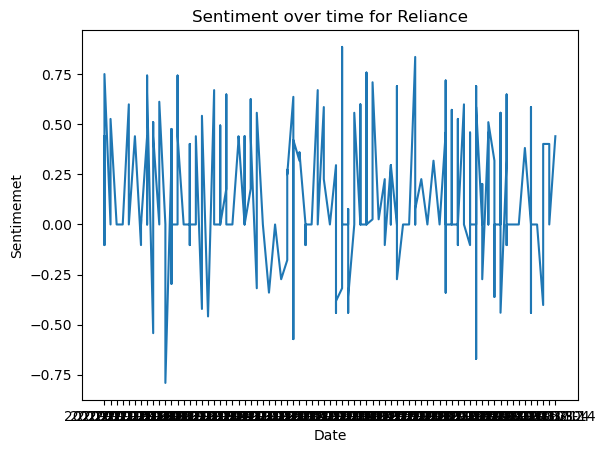

<Figure size 10000x500 with 0 Axes>

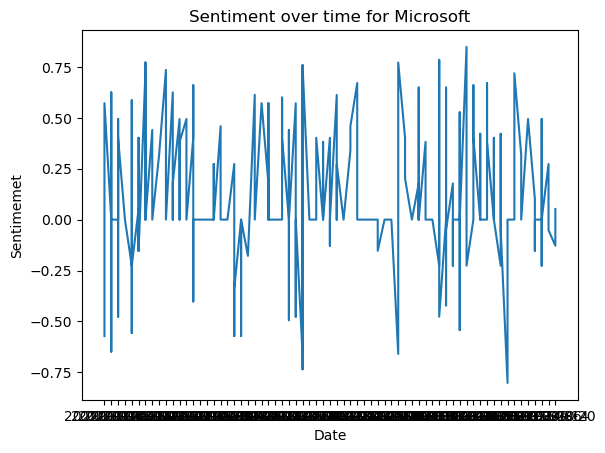

<Figure size 10000x500 with 0 Axes>

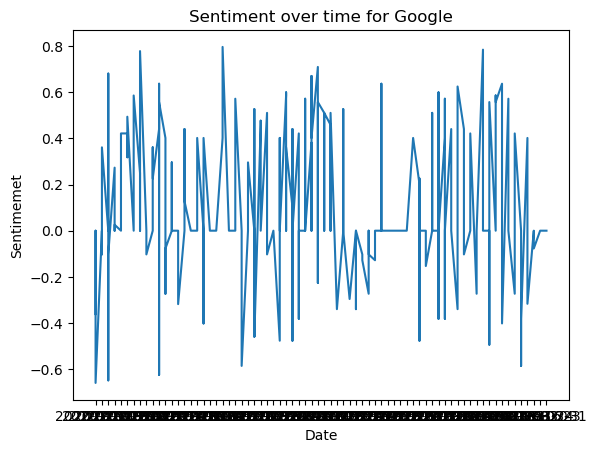

<Figure size 10000x500 with 0 Axes>

In [86]:
queries = {'Reliance': df1, 'Microsoft': df2, 'Google': df3}
for query, df in queries.items():
    plt.plot(df['Date'], df['sentiment'])
    plt.title(f'Sentiment over time for {query}')
    plt.xlabel('Date')
    plt.ylabel('Sentimemet')
    plt.figure(figsize = (100,5))
    plt.show()
   

# Getting the labels

In [87]:
def calculate_price_movement(df: pd.DataFrame, condition: str):
    """
    Adds a new column to the DataFrame indicating stock price movement over a specified time period.

    Parameters:
        df (pd.DataFrame): A DataFrame containing merged stock and news data.
        condition (str): Specifies the time period for price change calculation.
            - 'daily': Price change over one day.
            - 'weekly': Price change over one week.
            - 'monthly': Price change over one month.

    Returns:
        pd.DataFrame: The updated DataFrame with a new column "{conditon}_movement" representing price movement.
    """
    
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df = df.sort_values(by = 'Date')

    if condition =='daily':
        df['daily_movement'] =  None
        last_price = {}
        for i in range(len(df)):
            current_date= df.loc[i, 'Date']
            current_price = df.loc[i, 'Close']
            last_date = max([d for d in last_price.keys() if d<current_date], default = None)
            if last_date:
                df.loc[i, 'daily_movement'] = (
                    'increase' if current_price>last_price[last_date] else
                    'decrease' if current_price<last_price[last_date] else
                    'same'
                ) 
            last_price[current_date] = current_price
        return df
        
    elif condition == 'weekly':
        df['weekly_movement'] = None
        last_week_end = None

        for week_start in sorted(df['Date'].unique()):
            week_end = week_start+pd.Timedelta(days = 6)
            past_week_prices = df[(df['Date']>=last_week_end) & (df['Date']<week_start)]['Close']
            new_week_prices = df[(df['Date']>=week_start) & (df['Date']<=week_end)]['Close']

            if not past_week_prices.empty and not new_week_prices.empty:
                past_week_price = past_week_prices.iloc[-1]
                new_week_price = new_week_prices.iloc[-1]

                df.loc[df['Date']==week_start, 'weekly_movement'] = (
                    'increase' if new_week_price>past_week_price else
                    'decrease' if new_week_price<past_week_price else
                    'same'
                )
            last_week_end = week_end
        return df
            
    elif condition == 'monthly':
        df['monthly_movement'] = None
        last_month_end = None
        for month_start in sorted(df['Date'].unique()):
            month_end = month_start + relativedelta(months=1)-pd.Timedelta(days=1)
            past_month_prices = df[(df['Date']>=last_month_end) & (df['Date']< month_start)]['Close']
            new_month_prices = df[(df['Date']>=month_start) & (df['Date']<=month_end)]['Close']

            if not past_month_prices.empty and not new_month_prices.empty:
                past_month_price = past_month_prices.iloc[-1]
                new_month_price = new_month_prices.iloc[-1]

                df.loc[df['Date']==week_start, 'monthly_movement'] = (
                    'increase' if past_month_price<new_month_price else
                    'decrease' if past_month_price>new_month_price else
                    'same'
                )
            last_month_end = month_end
        return df
    else:
        raise ValueError(f"Invalid condition '{condition}'. Expected one of these: ['daily', 'weekly', 'monthly'].")
        return
        

In [88]:
df_1 = calculate_price_movement(df1, 'daily')
df_1.dropna(subset=['daily_movement'], inplace=True)
df_2 = calculate_price_movement(df2, 'daily')
df_2.dropna(subset=['daily_movement'], inplace=True)
df_3 = calculate_price_movement(df3, 'daily')
df_3.dropna(subset=['daily_movement'], inplace=True)

# Feature Extraction

## Word2Vec

In [89]:
df_1['tokenized_text'] = df_1['cleaned_text'].apply(lambda x: x.split())
df_2['tokenized_text'] = df_2['cleaned_text'].apply(lambda x: x.split())
df_3['tokenized_text'] = df_3['cleaned_text'].apply(lambda x: x.split())

In [90]:
def get_word2vec_embedding(text:list, model, vector_size = 20):
    """
    Coverts the sentences into a fixed size vector by averaging the word2vec embeddings of its words

    Parameters:
        text(list): list of tokenized words.
        model(word2vec): trained word2vec model
        vector_size(int): size of the word embedding

    Returns:
        np.array: Sentence embedding vector.
    """

    words = [word for word in text if word in model.wv]
    if not words:
        return np.zeros(vector.size)
    return np.mean([model.wv[word] for word in words], axis = 0)

In [91]:
word2vec_model1 = Word2Vec(sentences = df_1['tokenized_text'], vector_size = 100, window =5, min_count =2, workers = 4)
word2vec_model2 = Word2Vec(sentences = df_2['tokenized_text'], vector_size = 100, window =5, min_count =2, workers = 4)
word2vec_model3 = Word2Vec(sentences = df_3['tokenized_text'], vector_size = 100, window =5, min_count =2, workers = 4)

df_1['embedding'] = df_1['tokenized_text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model1))
df_2['embedding'] = df_2['tokenized_text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model2))
df_3['embedding'] = df_3['tokenized_text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model3))

## BERTopic 

In [92]:
bertopic_model_1 = BERTopic(nr_topics = 'auto')
topics_1, _ = bertopic_model_1.fit_transform(df_1['cleaned_text'])
df_1['topic'] = topics_1
bertopic_model_2 = BERTopic(nr_topics = 'auto')
topics_2, __ = bertopic_model_2.fit_transform(df_2['cleaned_text'])
df_2['topic'] = topics_2
bertopic_model_3 = BERTopic(nr_topics = 'auto')
topics_3, ___ = bertopic_model_3.fit_transform(df_3['cleaned_text'])
df_3['topic'] = topics_3

# Label Encoding 

In [93]:
data = pd.concat([df_1, df_2, df_3], ignore_index = True)
label_encoder = LabelEncoder()

data['labels'] = label_encoder.fit_transform(data['daily_movement'])

# Model Traning

## Test_train split

In [94]:
X = data[['sentiment', 'embedding', 'topic']].copy()
y = data['labels']

In [95]:
word2vec_features = np.vstack(X['embedding'].values)

X.drop(columns = ['embedding'], inplace = True)
word2vec_features_names = [f'word2vec_{i}' for i in range(word2vec_features.shape[1])]
X.join(pd.DataFrame(word2vec_features, columns= word2vec_features_names))

,sentiment,topic,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,...,word2vec_90,word2vec_91,word2vec_92,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99
0,-0.2732,5,-0.163594,0.324581,-0.080207,0.100541,0.052676,-0.403764,0.102313,0.694852,...,0.223068,0.132680,0.040994,0.124034,0.540155,0.408099,0.093115,-0.157769,0.106868,-0.097385
1,0.4404,0,-0.121192,0.231400,-0.057212,0.074029,0.038199,-0.290161,0.075813,0.497588,...,0.157004,0.095941,0.026200,0.088583,0.387029,0.287737,0.071966,-0.111718,0.080098,-0.070476
2,0.4404,0,-0.121192,0.231400,-0.057212,0.074029,0.038199,-0.290161,0.075813,0.497588,...,0.157004,0.095941,0.026200,0.088583,0.387029,0.287737,0.071966,-0.111718,0.080098,-0.070476
3,0.0000,0,-0.095849,0.190861,-0.047304,0.056820,0.028875,-0.236108,0.057605,0.398151,...,0.127538,0.075282,0.020854,0.069981,0.309907,0.234938,0.056468,-0.089469,0.058155,-0.052869
4,0.0000,0,-0.095849,0.190861,-0.047304,0.056820,0.028875,-0.236108,0.057605,0.398151,...,0.127538,0.075282,0.020854,0.069981,0.309907,0.234938,0.056468,-0.089469,0.058155,-0.052869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3885,0.1779,4,-0.049434,0.092027,0.064009,0.109940,-0.001180,-0.109822,-0.002653,0.227661,...,0.129268,0.010558,0.009608,0.014325,0.201353,0.173744,0.037659,-0.116438,0.052976,0.003658
3886,0.6249,0,-0.100382,0.222078,0.143256,0.257421,-0.006440,-0.260751,-0.001627,0.545611,...,0.310243,0.023790,0.008441,0.040805,0.478632,0.393847,0.069227,-0.260676,0.131884,-0.004499
3887,-0.3400,2,-0.065381,0.143690,0.096227,0.167962,-0.000988,-0.172238,0.001266,0.351899,...,0.201097,0.015962,0.008896,0.023221,0.309960,0.257333,0.046596,-0.166738,0.082930,-0.001453
3888,0.0000,-1,-0.086874,0.178457,0.123123,0.212528,-0.006854,-0.211593,0.004532,0.441858,...,0.251732,0.018681,0.008786,0.031630,0.395948,0.323254,0.057229,-0.219628,0.100922,0.000645


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42, stratify = y)

NameError: name 'train_test_split' is not defined